<a href="https://colab.research.google.com/github/JustFineNeuro/LDS_CONTROL_HMM/blob/main/CreatingLDSANDCONTROLLERs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from scipy import signal
import scipy.linalg
import numpy as np

Specify a linear state space model of the form w/signal independent noise:

Evolution/process equation
$x(t+1)=Ax(t)+Bu(t)+Normal(0,\sigma_1)$

Observation equation
$y(t)=Cx(t)+Dw(t)+Normal(0,\sigma_2)$


References
https://www.textroad.com/pdf/JAEBS/J.%20Appl.%20Environ.%20Biol.%20Sci.,%205(4S)1-11,%202015.pdf

In [37]:
#Sampling frequency =1/60 Hz

dt=1/60

#Discretized system for constant velocity joystick: 2D
A=np.matrix([[1 ,dt,0,0],[0 ,0,0,0],[0 ,0,1,dt],[0 ,0,0,0]])
B=np.array([[0],[1*dt],[0],[1*dt]])

C=np.array([[1],[1]])

type(A)==np.matrix


True

In [45]:
class LDS:
  def __init__(self,  ini_state: float, noise_var: float):
    self.ini_state = ini_state
    self.noise_var = noise_var
    self.A=np.matrix([])

  @property
  def transition(self):
    return self.A

  @transition.setter
  def transition(self,value):
    if type(value)==np.matrix:
      self.A=value
    else:
      raise ValueError('Transition matrix "A" must be a numpy matrix')



B=LDS(1,1)
B.transition(np.matrix([[1 ,dt,0,0],[0 ,0,0,0],[0 ,0,1,dt],[0 ,0,0,0]]))

TypeError: ignored

In [ ]:

  def dynamics_run(self,D, B, L):

    s = np.zeros(self.T)  # states initialization
    s[0] = self.ini_state
    noise = np.random.normal(0, self.noise_var, self.T)
    a = np.zeros(self.T - 1)

    for t in range(self.T - 1):
      # calculate the current action
      a[t] = L[t] * s[t]
      # calculate the next state
      s[t + 1] =D * s[t] + B * a[t] + noise[t]

    return s, a


In [30]:
def dlqr(A,B,Q,R):
  """
  solve the discrete-time system, steady-state (infinite horizon) LQR controller
  cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
  """
  #first, try to solve the ricatti equation
  X = np.matrix(scipy.linalg.solve_discrete_are(A,B,Q,R))

  #Compute the steady state
  K = np.matrix(scipy.linalg.inv(B.T*X*B+R)*(B.T*X*A))

  return K

def dlqr_ratio(A,B,rho):
  #TODO 
#P_store = zeros(2,2);
 #       P = Q;
  #      while norm(P-P_store)>0.001
   #         P_store = P;
    #        P = Q+A'*P*A-A'*P*B/(R+B'*P*B)*B'*P*A;
     #   end
          
      #  % Compute optimal control law (change R here)
       # K = (R+B'*P*B)\B'*P*A;
  return K

In [33]:
#@markdown Execute this cell to test dlqr function

dt=1/60

#Discretized system for constant velocity joystick: 1D
A=np.matrix([[1 ,dt],[0 ,0]])
B=np.array([[0],[dt**2]])

C=np.array([[1],[1]])


# Define our costs:
Q = np.matrix([[1,0],[0,0]])
R = np.matrix([[20]])
dlqr(A,B,Q,R)

matrix([[0.38729799, 0.00645497]])

In [ ]:
class LDS:
  def __init__(self, T: int, ini_state: float, noise_var: float):
    #self.T = T  # time horizon
    self.ini_state = ini_state
    self.noise_var = noise_var



  def step_update(self,D, B, L):

    s = np.zeros(self.T)  # states initialization
    s[0] = self.ini_state
    noise = np.random.normal(0, self.noise_var, self.T)
    a = np.zeros(self.T - 1)

    for t in range(self.T - 1):
      # calculate the current action
      a[t] = L[t] * s[t]
      # calculate the next state
      s[t + 1] =D * s[t] + B * a[t] + noise[t]

    return s, a

In [5]:
class LQR(LDS):
  def __init__(self, T, ini_state, noise_var):
    super().__init__(T, ini_state, noise_var)
    self.goal = np.zeros(T)  # The class LQR only supports g=0

  def control_gain_LQR(self, D, B, rho):
    P = np.zeros(self.T)  # Dynamic programming variable
    L = np.zeros(self.T - 1)  # control gain
    P[-1] = 1

    for t in range(self.T - 1):
        P_t_1 = P[self.T - t - 1]
        P[self.T - t-2] = (1 + P_t_1 * D**2 - D * P_t_1 * B / (
                rho + P_t_1 * B) * B**2 * P_t_1 * D)

        L[self.T - t-2] = - (1 / (rho + P_t_1 * B**2) * B * P_t_1 * D)
    return L

  def calculate_J_state(self, s:np.ndarray):
    # calculate the state
    J_state = np.sum((s - self.goal)**2)

    return J_state

  def calculate_J_control(self, a:np.ndarray):
    # calculate the control
    J_control = np.sum(a**2)

    return J_control


In [6]:
#@markdown Execute this cell to include class
#@markdown for LQR control to desired time-varying goal

class LQR_tracking(LQR):
  def __init__(self, T, ini_state, noise_var, goal):
    super().__init__(T, ini_state, noise_var)
    self.goal = goal

  def dynamics_tracking(self, D, B, L):

    s = np.zeros(self.T) # states intialization
    s[0] = self.ini_state

    noise = np.random.normal(0, self.noise_var, self.T)

    a = np.zeros(self.T) # control intialization
    a_bar = np.zeros(self.T)
    for t in range(self.T - 1):
        a_bar[t] = ( - D * s[t] + self.goal[t + 1]) / B
        a[t] =  L[t] * (s[t] - self.goal[t]) + a_bar[t]
        s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s, a, a_bar

  def calculate_J_state(self,s):
    J_state = np.sum((s-self.g)**2)
    return J_state

  def calculate_J_control(self, a, a_bar):
    J_control = np.sum((a-a_bar)**2)
    return J_control

In [15]:

def simulate_tracking(rho=20., noise_var=0.1, goal_func='sin'):
  D, B, T, ini_state = 0.9, 2., 100, 0.
  if goal_func == 'sin':
      goal = np.sin(np.arange(T) * 2 * np.pi * 5 / T)
  elif goal_func == 'step':
      goal = np.zeros(T)
      goal[int(T / 3):] = 1.
  elif goal_func == 'ramp':
      goal = np.zeros(T)
      goal[int(T / 3):] = np.arange(T - int(T / 3)) / (T - int(T / 3))

  lqr_time = LQR_tracking(T, ini_state, noise_var, goal) #initiates an tracking problem independent of system
  L = lqr_time.control_gain_LQR(D, B, rho)
  s_lqr_time, a_lqr_time, a_bar_lqr_time = lqr_time.dynamics_tracking(D, B, L)
  return s_lqr_time, L

[-0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0.10812262
 -0.10812262 -0.10812262 -0.10812262 -0.10812262 -0

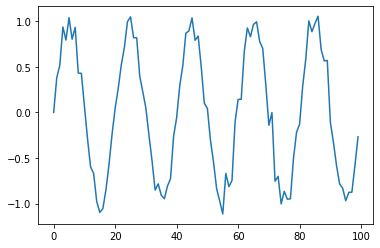

In [16]:
ss,L=simulate_tracking()
print(L)
import matplotlib.pyplot as plt
plt.plot(ss)
plt.show()
